This notebook is based on Aurelien Geron's Chapter 3 of Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow book (2nd edition)

Book link: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

Geron's git hub link for this chapter 3: https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb


# Intro

Using the MNIST dataset to learn classification problem in ML

# Setup

In [87]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [88]:
# downlaod dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version =1)
mnist.keys

<function Bunch.keys>

In [89]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [90]:
# see size of data
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

This means that there are 70000 images and each image has 784 features

Each image has 784 features because they are 28 x 28 pixels

Saving figure some_digit_plot


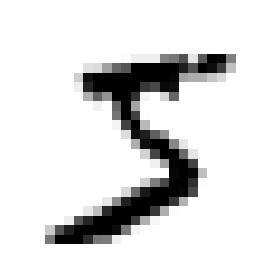

In [91]:
# let's have a look at one
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

save_fig("some_digit_plot")
plt.show()

In [92]:
# lets check the label for the first datay
y[0]

'5'

In [93]:
# Note that the label is a string
# lets change them to numbers (integers)
y = y.astype(np.uint8)

## plot more digits

In [94]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [95]:
def plot_digits(instances, images_per_row = 10,**options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation = 'nearest')
    plt.axis('off')

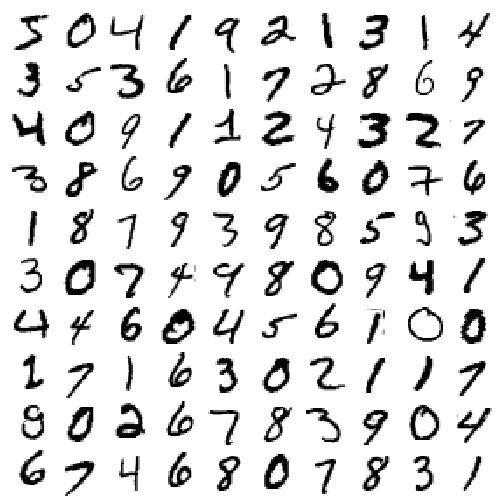

In [96]:
# plot the first 100 data
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
plt.show()

## Split to train test dataset

In [97]:
# MNIST has actually been split as this. First 60k dataset are training, last 10k are test set
# The training set also has been shuffled (making sure that all digits are included)
# soem learning algorithm are sensitive to order of training isntances. They perform poorly if they get many similar instances in a row
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Start from Binary Classifier

Start with a simple classifier. We will create a "number 5 detector". So detect 5 or not 5

In [11]:
y_train_5 = (y_train == 5) # create true for all 5's and false otherwise
y_test_5 = (y_test == 5)

## SGD classifier

Stochastic Gradient Descent classifier. 

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5) # note that the targer variable now whether the number is 5 or not

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit]) # note: we created some_digit earlier as X[0] which is 5

array([ True])

### Accuracy via cross-validation

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

alternatively:

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Either way, 96% accuracy on predictiomns 

In [16]:
# lets classify every single image in the not5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

Hmm 90% accuracy. if you guess a number is not 5, you should be 90% right of the time

This means accuracy is not preferred performance measure for classifiers, especially with skewed datasets

### Confusion matrix

First we need some prediction. But do not touch the test set

One option is to use Cross val predict

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
# now the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# each cell compared actual vs prediction

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# now if we pretend we have a perfect model by copying the y_train_5
# we should see 0's in 2 columns
y_train_perfect_conditions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_conditions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision & Recall

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

This suggest the detecter isnt as good as before. When it calims 5, it is correct 84% of the time. And the model only predicts 65% of the 5s

### F1 score

Combination of precision and recall

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
# to see the threshold of the classifier decision function
y_scores = sgd_clf.decision_function([some_digit])   # note that some_digit is X[0] which is a 5
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# the default SGD classifier use a threshold of 0
# lets say we raise this to 8k

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

When threshold = 0. It detects a 5 which is actually a 5. If we increase the threshold, it doesnt detect a 5 anymore (as false)

### How to decide threshold?

In [25]:
# lets do a cross val preduct again, but this time we want the decision score instead of making a prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
# we can use precision recall curve to compute precision and recall for all possible threshold
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


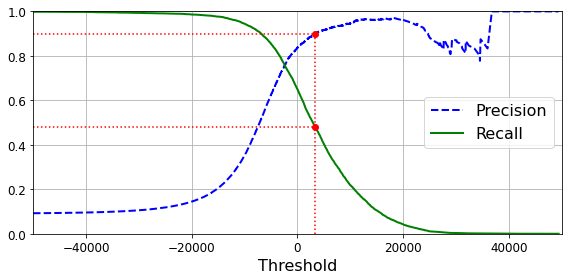

In [27]:
# plot the precision recall curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [28]:
recall_90_precision, threshold_90_precision

(0.4799852425751706, 3370.0194991439557)

Saving figure precision_vs_recall_plot


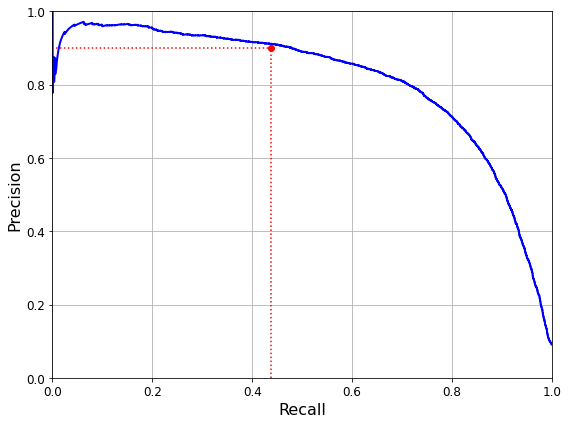

In [29]:
# alternatviely precision recall curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")

We can see here that after 70% recall the precision drop sharply. We want to select precision/recall tradeoff before this drop. say around 60%

In [30]:
# so if we want 90% precision, use the precision, recall vs thereshold plot
recall_90_precision, threshold_90_precision

(0.4799852425751706, 3370.0194991439557)

In [31]:
# Ex: if we want to make the prediciton on the training set, at this 90% threshold for precision
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [32]:
# and the precision and recall score are:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

Great. we have a 90% precision classifier

### ROC curve

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


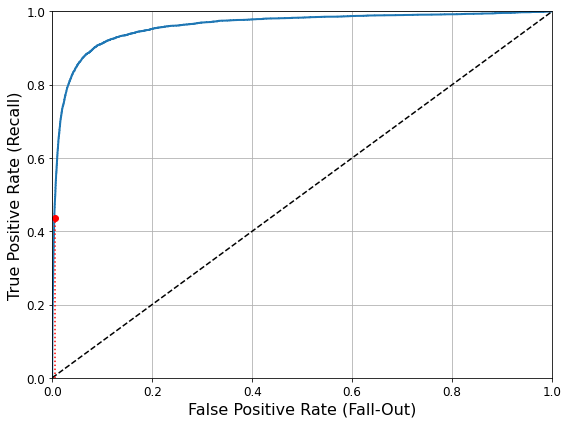

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True) 

plt.figure(figsize=(8, 6))    
plot_roc_curve(fpr,tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

The dotted line is a purely random classifier

One way to compare is to measure the area under a curve (AUC). Perfect classifier has AUC = 1, a random AUC = 0.5

In [35]:
# compute the AUC of the curve above
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### When to use PrecisionRecall curve and ROC curve

USE PR curve when positive class is rare or when you care more about FP rather than FN. Otherwise use ROC curve

In this example, ROC AUC score is high. So classifier looks good. But, there are very few positive (the 5s) compared to the negative (non 5s). In contrast, looking at the ROC curve, there is room for improvement (curve should be closer to top rigth corner)

## Random Forest Classifier

Repeat for random forest classifer

Note: RandomForest does not have decision_function() -> it uses predict_proba() method

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [37]:
# ROC needs label and score. Instead of score, we will give class probabilities. 
# Lets use positive class probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

### ROC curve & AUC

Saving figure roc_curve_comparison_plot


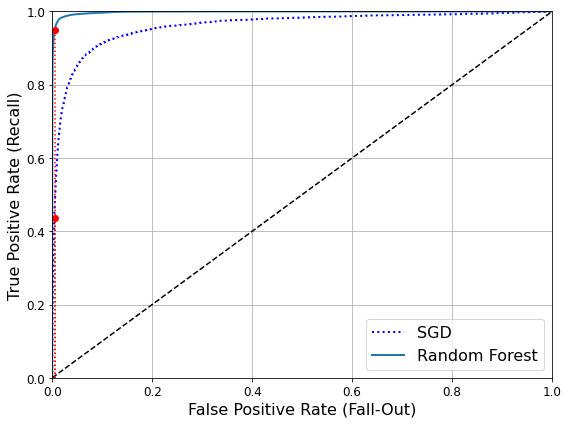

In [38]:
#Plot the ROC For RF and SGD
plt.figure(figsize=(8, 6))    
plt.plot(fpr,tpr,'b:',linewidth =2,label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,label='Random Forest')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [39]:
# Comparing the AUC score between SGD and RF
roc_auc_score_sgd = roc_auc_score(y_train_5, y_scores)
roc_auc_score_rf = roc_auc_score(y_train_5, y_scores_forest)
roc_auc_score_sgd, roc_auc_score_rf

(0.9604938554008616, 0.9983436731328145)

### Precision and recall

In [40]:
# for SGD earlier
prec_score_sgd = precision_score(y_train_5, y_train_pred)
recall_score_sgd = recall_score(y_train_5, y_train_pred)
prec_score_sgd, recall_score_sgd

(0.8370879772350012, 0.6511713705958311)

In [41]:
# for RF

# First make cross val predict
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

prec_score_rf = precision_score(y_train_5, y_train_pred_forest)
recall_score_rf = recall_score(y_train_5, y_train_pred_forest)
prec_score_rf, recall_score_rf

(0.9905083315756169, 0.8662608374838591)

Seems like RF perform better than SGD. Both in term of AUC score and precision-recall

## Reflection

Why we use ROC for the RF? at 4.1.7 we have discussed that using PR curve is better

# Multiclass classification

## Start with SVC

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5 because we train for many data
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
# Call decision function to see the score for each class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [44]:
# highest score is for digit?
np.argmax(some_digit_scores) 

#note that this refers to the location of the digit (index) in the classes. not as digit 5
# The highest score (9.297) is at the 5th index

5

In [45]:
svm_clf.classes_
svm_clf.classes_[5] #this is to find what digit refers to the 5th location

5

In [46]:
# this shows how many classifiers it trains. Should show many classifiers
#len(ovr_clf.estimators_)

### Forcing SVC through OVR classifier

Normally, SVC uses an OVO method. BUt you can force SVC to use OVR

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
# this shows how many classifiers it trains. Should show only 10 classifiers
len(ovr_clf.estimators_)

10

## With SGD classifier

In [114]:
# note using subset of the data to speed up
sgd_clf.fit(X_train[:10000], y_train[:10000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [99]:
sgd_clf.decision_function([some_digit])

array([[-1319644.0334316 , -1094450.22293128,  -477415.20666682,
          -13106.10131312, -1269452.57717759,    82661.50523942,
         -695502.52263771,  -781968.57959698,  -366826.32000484,
         -461749.07969019]])

SGD is quite confident. Almost all scores are negative. Highest score is for the 5th index with a score of 82661

In [100]:
# evaluate with cross validation
cross_val_score(sgd_clf, X_train[:1000], y_train[:1000], cv=3, scoring='accuracy')

array([0.8422619 , 0.81081081, 0.7734139 ])

### Applying standard scaler

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

array([0.85416667, 0.82582583, 0.81268882])

Standardisation slightly improve results

# Error analysis

## Checking confusion matrix

In [53]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:5000], y_train[:5000], cv=3)
conf_mx = confusion_matrix(y_train[:5000], y_train_pred[:5000])
conf_mx

array([[460,   0,   1,   2,   2,   9,   3,   0,   2,   0],
       [  0, 535,   5,   2,   1,   5,   0,   1,  13,   1],
       [  3,  10, 411,  14,  14,   5,   9,   6,  16,   0],
       [  2,   4,  18, 404,   0,  37,   1,  11,  11,   5],
       [  4,   2,   7,   2, 482,   0,   6,   2,  10,  20],
       [  6,   5,   3,  16,   8, 353,   9,   1,  22,  11],
       [  4,   4,   9,   0,   6,  10, 464,   0,   4,   0],
       [  3,   3,   3,   4,   9,   0,   0, 495,   0,  33],
       [  1,  16,  15,  15,   2,  10,   9,   5, 379,  10],
       [  6,   4,   4,   6,  15,   5,   0,  24,   7, 424]], dtype=int64)

Saving figure confusion_matrix_plot


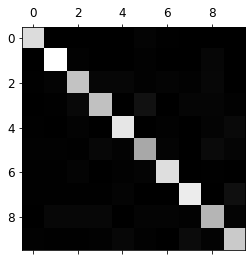

In [54]:
# You can even plot the matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()



In [55]:
# divide each value in confusion matrix by th enumber of images in the corresponding class so you can compare error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

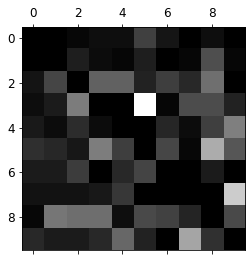

In [56]:
# Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looking at the above, column for class 8 is quite bright. This means many images get mis classfied as 8. 3 and 5 often miss classified too

Analysing this give insight how to improve your classifier

One good way to analyse individual error is to plot examples. lets plot 3s and 5s

Saving figure error_analysis_digits_plot


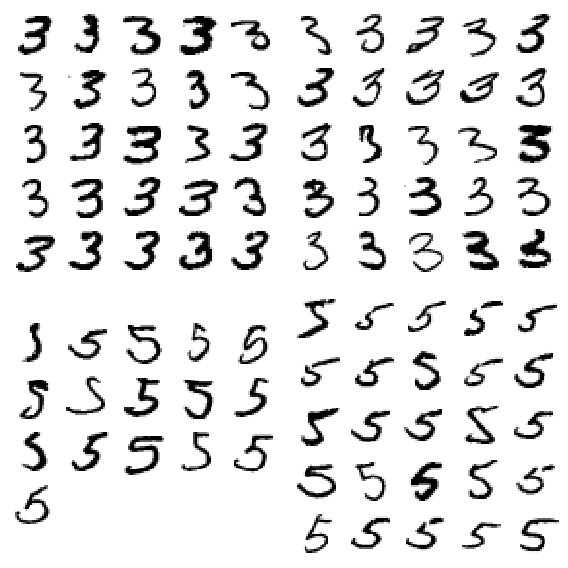

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[:5000][(y_train[:5000] == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[:5000][(y_train[:5000] == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[:5000][(y_train[:5000] == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[:5000][(y_train[:5000] == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Top left and bottom right are those that are classified are correct

Top right and bottom left are those that are classfied as wrong. However, some of these are obvious that the model is wrong

One reason is we used a simple SGDClassifier which is a linear model. All it does, is assign a weight per class to each pixel. When it sees a new image, it just sums up the weighted pixel to get a score for each class. Since 3s and 5s differ by a few pixels, this model will easily confsue them

# Multi label classification

Multi label is when classifier output multiple classes for each isntance. In face recognisiton program, if we train for persom A, B, C and we feed a model that only shows A and C, we want the model to output [1,0,1]



In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)    #is the digit large?
y_train_odd = (y_train % 2 == 1)  #is it odd? ie: if divided by 2, reminder is 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
knn_clf.predict([some_digit]) #remeber, some_digit is X[0] which is the digit 5
# this should output false,true

array([[False,  True]])

## Evaluate with F1

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled[:5000], y_multilabel[:5000], cv=3)
f1_score(y_multilabel[:5000], y_train_knn_pred, average ='macro')

0.924741214550497

# Multi output classification

Each label can be multiclass. Example is for clean digit image. Classifier output is multilabel (one label per pixel), and each label has different values (pixel intensity)

In [70]:

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


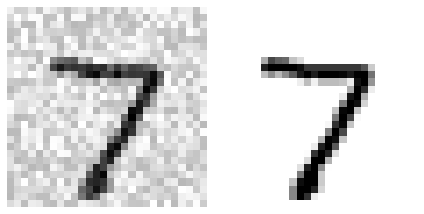

In [84]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


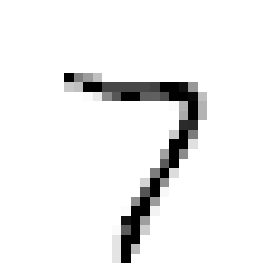

In [85]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Attempt to predict or test

In [115]:
X_test.shape, y_test.shape

((10000, 784), (10000,))

Assume SGD is our best model

In [116]:
y_final_predictions = sgd_clf.predict(X_test)

## Compute confusion matrix

In [117]:
conf_mx_final = confusion_matrix(y_final_predictions,y_test)
conf_mx_final

array([[ 955,    2,   15,    5,    3,   18,   18,    3,    8,   15],
       [   0, 1060,   11,    0,    2,    1,    3,    4,    6,    3],
       [   1,    3,  767,    9,    3,    2,    3,   11,    3,    1],
       [   1,    7,   55,  852,    9,   50,   11,   13,   20,   20],
       [   0,    0,    7,    3,  764,    5,    4,    6,    6,   27],
       [   5,    2,    4,   13,    3,  647,   11,    4,   14,    8],
       [   7,    5,   18,    4,   15,   16,  881,    1,    9,    1],
       [   2,    1,   13,   17,   29,    7,    4,  944,    9,  112],
       [   8,   54,  139,  101,  111,  142,   23,   22,  894,  121],
       [   1,    1,    3,    6,   43,    4,    0,   20,    5,  701]],
      dtype=int64)

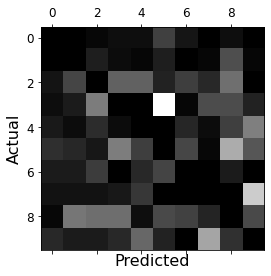

In [118]:
# plot
#normalised, fill the diagonal with 0 and plot
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.show()

In [112]:
# Compute the precision and recall score
#precision_score(y_final_predictions,y_test), recall_score(y_final_predictions,y_test)